In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('AdultDataCleared.csv', index_col=0)

In [3]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,High School,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,Compulsory,7,Married,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
workclass_ = pd.get_dummies(df['workclass'])
marital_ = pd.get_dummies(df['marital-status'])
occupation_ = pd.get_dummies(df['occupation'])
relationship_ = pd.get_dummies(df['relationship'])
race_ = pd.get_dummies(df['race'])
sex_ = pd.get_dummies(df['sex'])
country_ = pd.get_dummies(df['native-country'])
edn_ = pd.get_dummies(df['education'])

In [5]:
X = pd.concat([df[['age','capital-gain', 'hours-per-week']], workclass_ , marital_, occupation_, relationship_, race_, sex_, edn_, country_ ], axis=1)
y = df['Salary']

In [6]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_temp = X.copy()
X_temp['age'] = std.fit_transform(X_temp[['age']])

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_temp = pca.fit_transform(X_temp)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y, test_size=0.05, random_state=42)

In [9]:
from sklearn.svm import SVC

In [10]:
params = {
        'C': [0.1, 1, 10, 100, 1000], 
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
             }

In [11]:
from sklearn.model_selection import RandomizedSearchCV

In [12]:
svm = SVC()
rv = RandomizedSearchCV(svm, params, n_iter=10, cv=3, verbose=1)

In [13]:
rv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']},
                   verbose=1)

In [14]:
rv.best_params_

{'kernel': 'rbf', 'gamma': 0.01, 'C': 100}

In [15]:
rv.best_score_

0.8539700067631544

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pred_ada = rv.predict(X_test)
print(confusion_matrix(y_test, pred_ada), "\n")
print(classification_report(y_test, pred_ada), "\n")
print(accuracy_score(y_test, pred_ada))

[[7747  449]
 [1049 1501]] 

              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      8196
        >50K       0.77      0.59      0.67      2550

    accuracy                           0.86     10746
   macro avg       0.83      0.77      0.79     10746
weighted avg       0.85      0.86      0.85     10746
 

0.8605992927600968


In [17]:
from joblib import load, dump

In [18]:
dump(rv, 'SVMModel.joblib')

['SVMModel.joblib']

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc

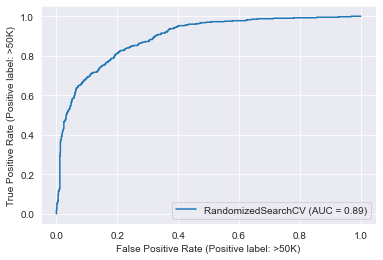

In [20]:
plot_roc_curve(rv, X_val, y_val)

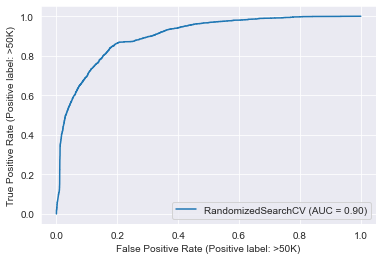

In [21]:
plot_roc_curve(rv, X_test, y_test)

In [22]:
y_true = np.where(y_test==">50K", 1, 0)
y_score = np.where(pred_ada==">50K", 1, 0)

In [23]:
roc_auc_score(y_true, y_score)

0.766922315046077

In [24]:
n_classes = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true==i, y_score==i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

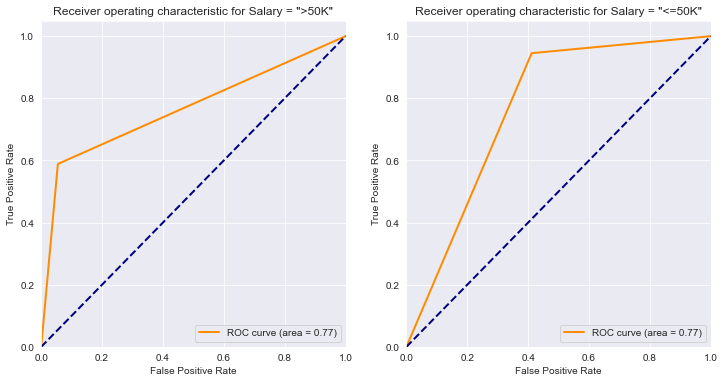

In [28]:
plt.figure(figsize=(12,6))
lw = 2

plt.subplot(1,2,1)
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Salary = ">50K"')
plt.legend(loc="lower right")

plt.subplot(1,2,2)
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Salary = "<=50K"')
plt.legend(loc="lower right")


plt.show()